# Model Fitness Customer Churn Analysis

## Project Description

Model Fitness, a chain of gyms, is developing a data‑driven customer engagement strategy. To combat customer churn (“silent departures”),  this analysis:

1. **Predicts** each member’s probability of churn in the next month.  
2. **Profiles** key customer segments and describes their main characteristics.  
3. **Identifies** the most impactful factors driving churn.  
4. **Recommends** retention measures, including target groups and service improvements.

Churn is defined here as a member who fails to visit the gym for a full month. Although exceptions (e.g., vacations) exist, this definition captures the typical “quiet” departure.

---

## Analysis Objectives

1. **Churn Probability Modeling**  
   - Train and evaluate a classification model (e.g., logistic regression, random forest).  
   - Calibrate and interpret predicted probabilities.

2. **Customer Profiling**  
   - Segment members by usage patterns, demographics, and engagement metrics.  
   - Highlight high‑risk vs. loyal cohorts.

3. **Feature Importance**  
   - Analyze which behavioral and demographic features correlate most strongly with churn.  

4. **Strategic Recommendations**  
   - Define target segments for proactive outreach.  
   - Suggest personalized retention actions (e.g., tailored offers, check‑in reminders).  
   - Document any additional patterns observed (e.g., seasonal drop‑off).

###  Available Features

#### Customer Profile (from the previous month)
- **`gender`**: Customer's gender.
- **`Near_Location`**: Whether the customer lives or works near the gym.
- **`Partner`**: Indicates if the customer works for a partner company (eligible for discounts).
- **`Promo_friends`**: Whether the customer signed up using a "bring-a-friend" promotion.
- **`Phone`**: Indicates if a phone number was provided.
- **`Age`**: Customer's age.
- **`Lifetime`**: Number of months since the customer first visited the gym.

#### Membership, Visits, and Spending Data
- **`Contract_period`**: Contract duration — 1, 3, 6, or 12 months.
- **`Month_to_end_contract`**: Number of months remaining until the contract expires.
- **`Group_visits`**: Whether the customer attends group sessions (`1`) or not (`0`).
- **`Avg_class_frequency_total`**: Average weekly class attendance over the customer's lifetime.
- **`Avg_class_frequency_current_month`**: Average weekly class attendance during the current month.
- **`Avg_additional_charges_total`**: Total amount spent on extra services (e.g., café, products, massages).

#### Target Variable
- **`Churn`**: Binary indicator of whether the customer canceled their membership in the current month (`1` = churned, `0` = retained).

---

## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score 
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans



## Read dataframe

In [2]:
df = pd.read_csv('datasets/gym_churn_us.csv')

## Exploratory Data Analysis

In [3]:
#showing the shape, info and head of the dataframe
print(df.shape)
print(df.info())
display(df.head())

(4000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-n

gender  Near_Location  Partner  Promo_friends  Phone  Contract_period  \
0       1              1        1              1      0                6   
1       0              1        0              0      1               12   
2       0              1        1              0      1                1   
3       0              1        1              1      1               12   
4       1              1        1              1      1                1   

   Group_visits  Age  Avg_additional_charges_total  Month_to_end_contract  \
0             1   29                     14.227470                    5.0   
1             1   31                    113.202938                   12.0   
2             0   28                    129.448479                    1.0   
3             1   33                     62.669863                   12.0   
4             0   26                    198.362265                    1.0   

   Lifetime  Avg_class_frequency_total  Avg_class_frequency_current_month  \
0         3                   0.020398                           0.000000   
1         7                   1.922936                           1.910244   
2         2                   1.859098                           1.736502   
3         2                   3.205633                           3.357215   
4         3                   1.113884                           1.120078   

   Churn  
0      0  
1      0  
2      0  
3      0  
4      0

There is a DataFrame of 4000 rows, good for making predictions, no null values are found and I don't see why data conversion should be performed.

In [4]:
#Descriptive statistics of the dataframe
display(df.describe())

gender  Near_Location      Partner  Promo_friends        Phone  \
count  4000.000000    4000.000000  4000.000000    4000.000000  4000.000000   
mean      0.510250       0.845250     0.486750       0.308500     0.903500   
std       0.499957       0.361711     0.499887       0.461932     0.295313   
min       0.000000       0.000000     0.000000       0.000000     0.000000   
25%       0.000000       1.000000     0.000000       0.000000     1.000000   
50%       1.000000       1.000000     0.000000       0.000000     1.000000   
75%       1.000000       1.000000     1.000000       1.000000     1.000000   
max       1.000000       1.000000     1.000000       1.000000     1.000000   

       Contract_period  Group_visits          Age  \
count      4000.000000   4000.000000  4000.000000   
mean          4.681250      0.412250    29.184250   
std           4.549706      0.492301     3.258367   
min           1.000000      0.000000    18.000000   
25%           1.000000      0.000000    27.000000   
50%           1.000000      0.000000    29.000000   
75%           6.000000      1.000000    31.000000   
max          12.000000      1.000000    41.000000   

       Avg_additional_charges_total  Month_to_end_contract     Lifetime  \
count                   4000.000000            4000.000000  4000.000000   
mean                     146.943728               4.322750     3.724750   
std                       96.355602               4.191297     3.749267   
min                        0.148205               1.000000     0.000000   
25%                       68.868830               1.000000     1.000000   
50%                      136.220159               1.000000     3.000000   
75%                      210.949625               6.000000     5.000000   
max                      552.590740              12.000000    31.000000   

       Avg_class_frequency_total  Avg_class_frequency_current_month  \
count                4000.000000                        4000.000000   
mean                    1.879020                           1.767052   
std                     0.972245                           1.052906   
min                     0.000000                           0.000000   
25%                     1.180875                           0.963003   
50%                     1.832768                           1.719574   
75%                     2.536078                           2.510336   
max                     6.023668                           6.146783   

             Churn  
count  4000.000000  
mean      0.265250  
std       0.441521  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max       1.000000

Some conclusions at the firt eye: <br>
It seems the gender balance is pretty even. <br>
Most clients live near the gym. <br>
Half work at a partner company. <br>
Most clients gave their phone number. <br>
The average contract is 3 to 6 months. <br>
Less than half attend group sessions. <br>
The average age is 29. <br>
People tend to spend money at the gym; $146 on average is a good amount of money. <br>
People go to the gym about twice a week. <br>
Few people have dropped out. <br>

In [5]:
#check churn statistics
churn_group = df.groupby('Churn')
display(churn_group.mean())

gender  Near_Location   Partner  Promo_friends     Phone  \
Churn                                                               
0      0.510037       0.873086  0.534195       0.353522  0.903709   
1      0.510839       0.768143  0.355325       0.183789  0.902922   

       Contract_period  Group_visits        Age  Avg_additional_charges_total  \
Churn                                                                           
0             5.747193      0.464103  29.976523                    158.445715   
1             1.728558      0.268615  26.989632                    115.082899   

       Month_to_end_contract  Lifetime  Avg_class_frequency_total  \
Churn                                                               
0                   5.283089  4.711807                   2.024876   
1                   1.662582  0.990575                   1.474995   

       Avg_class_frequency_current_month  
Churn                                     
0                               2.027882  
1                               1.044546

Some conclusions: <br>
It can be seen that those who dropped out went to the gym once a week, were only enrolled for about a month, did not work for a partner company, and did not come through a friend.

### Distributions of characteristics for those who left (cancellation) and for those who stayed.

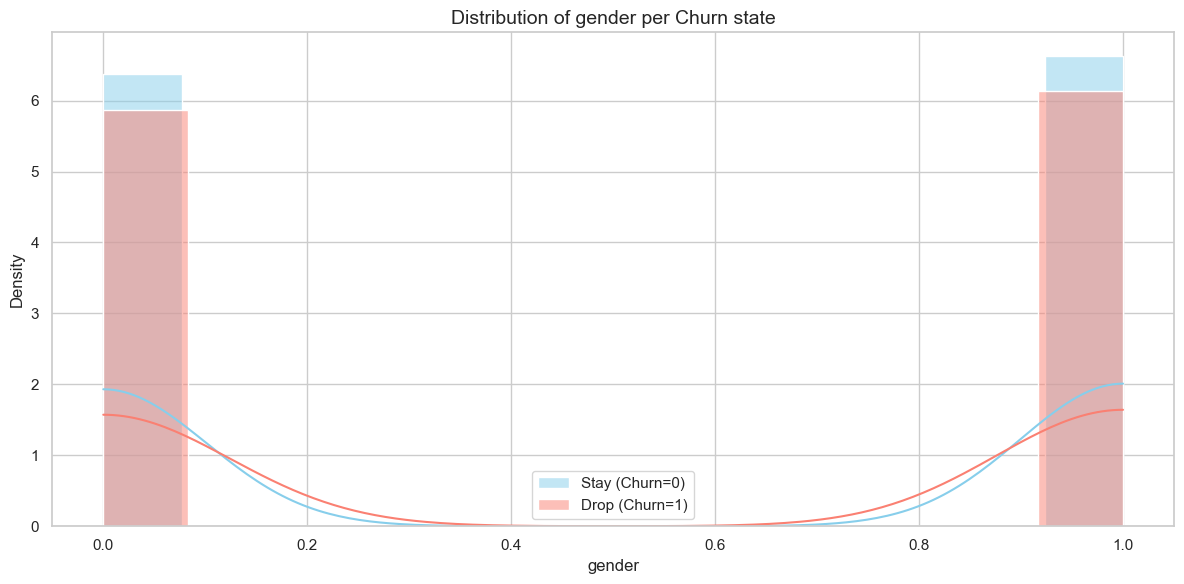

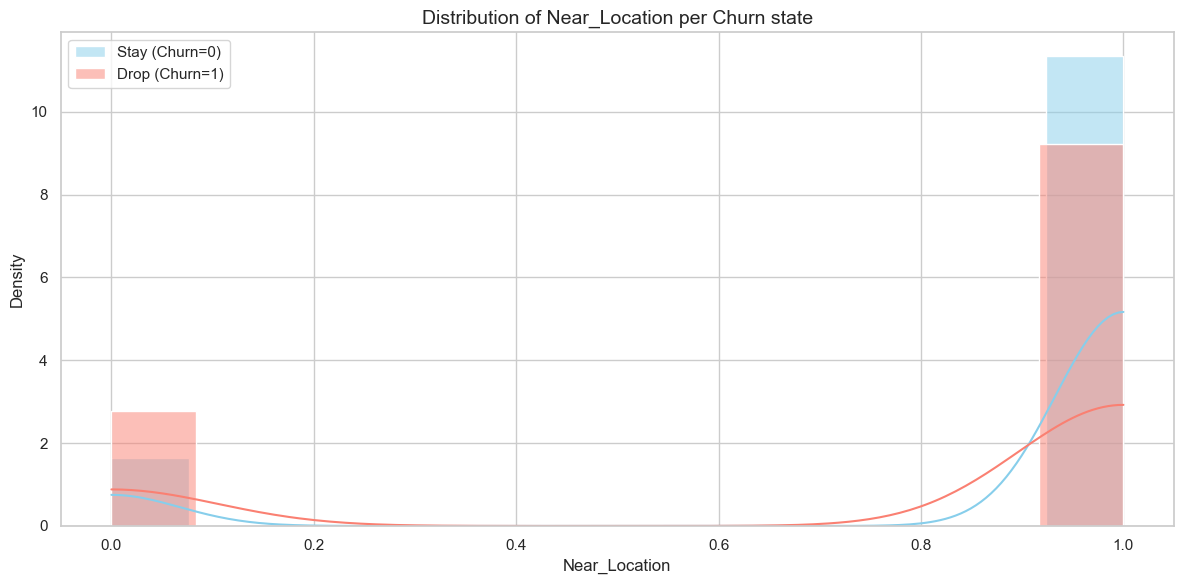

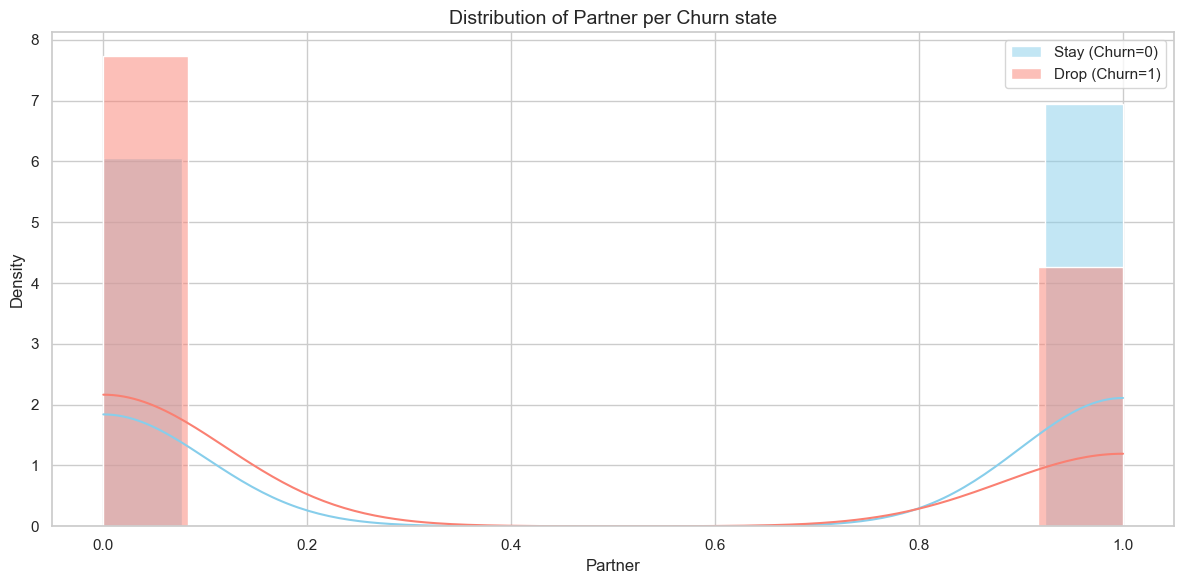

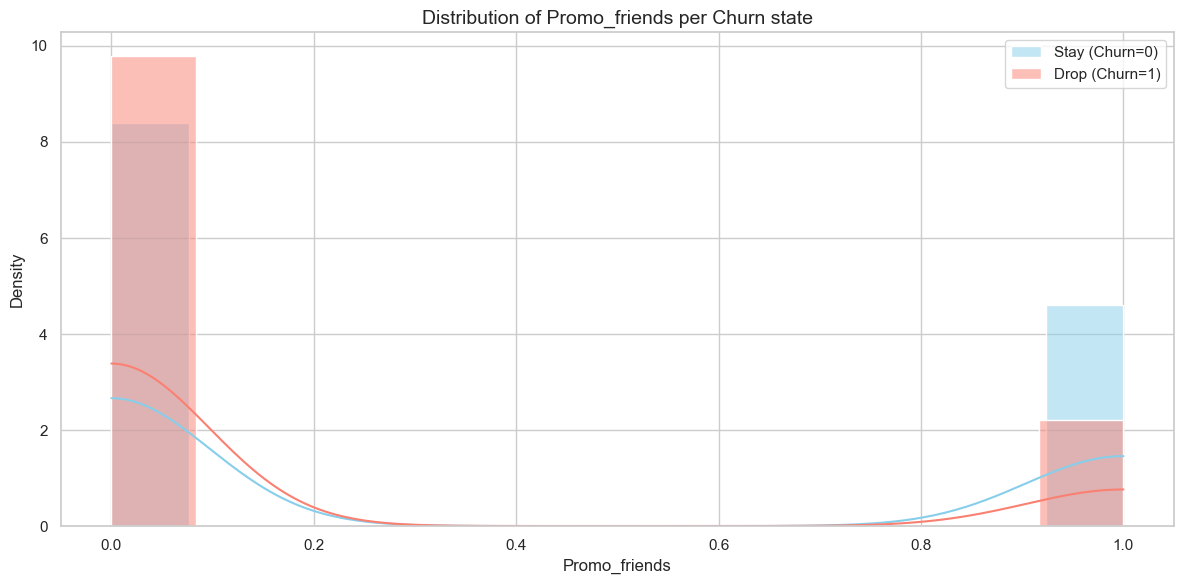

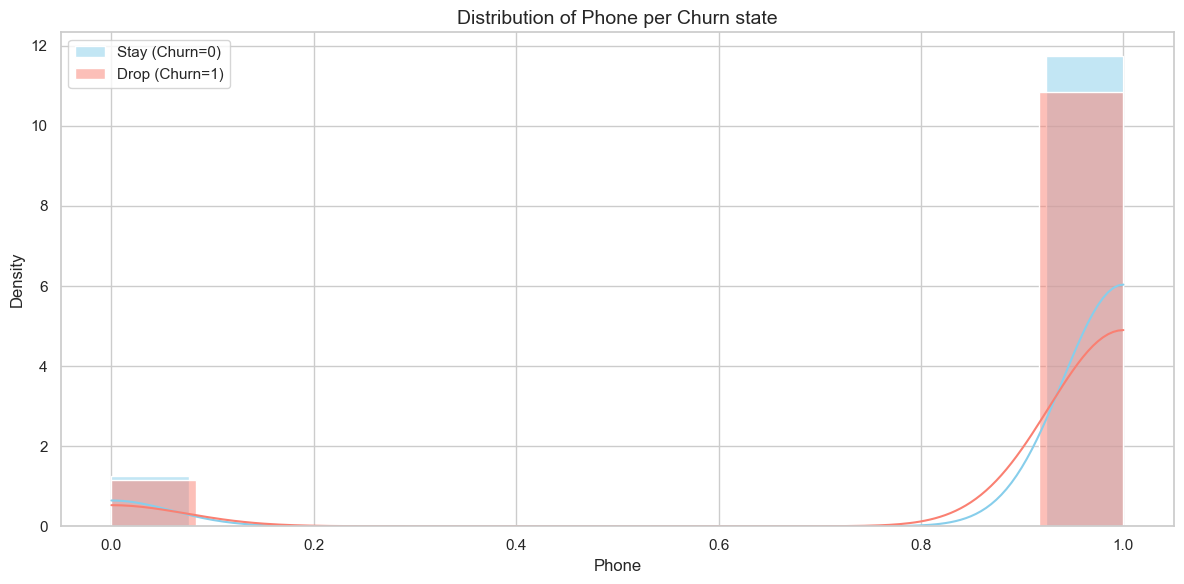

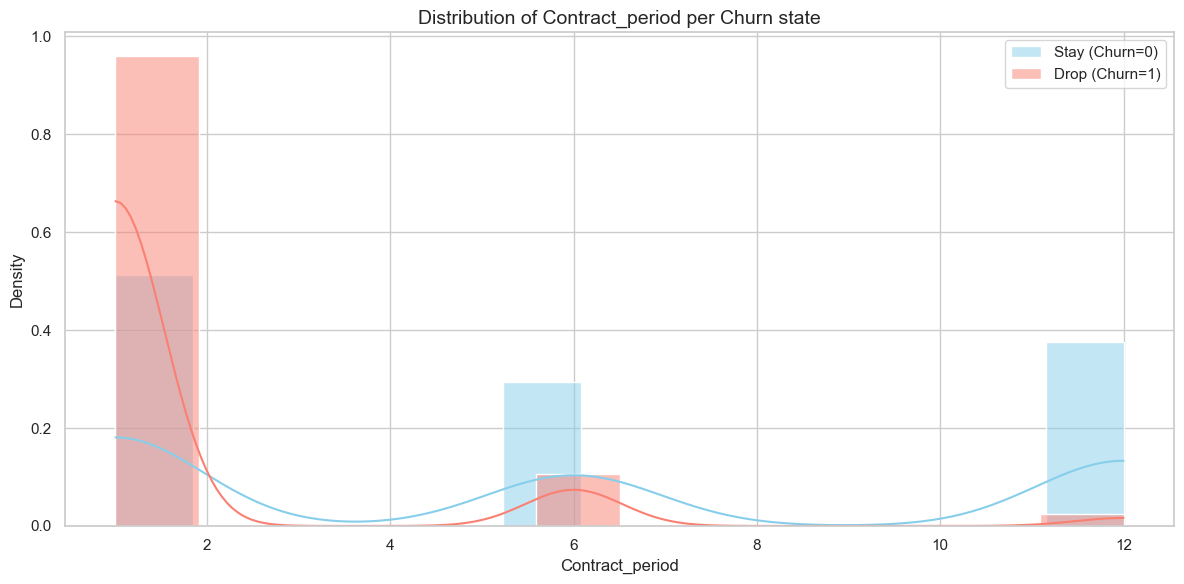

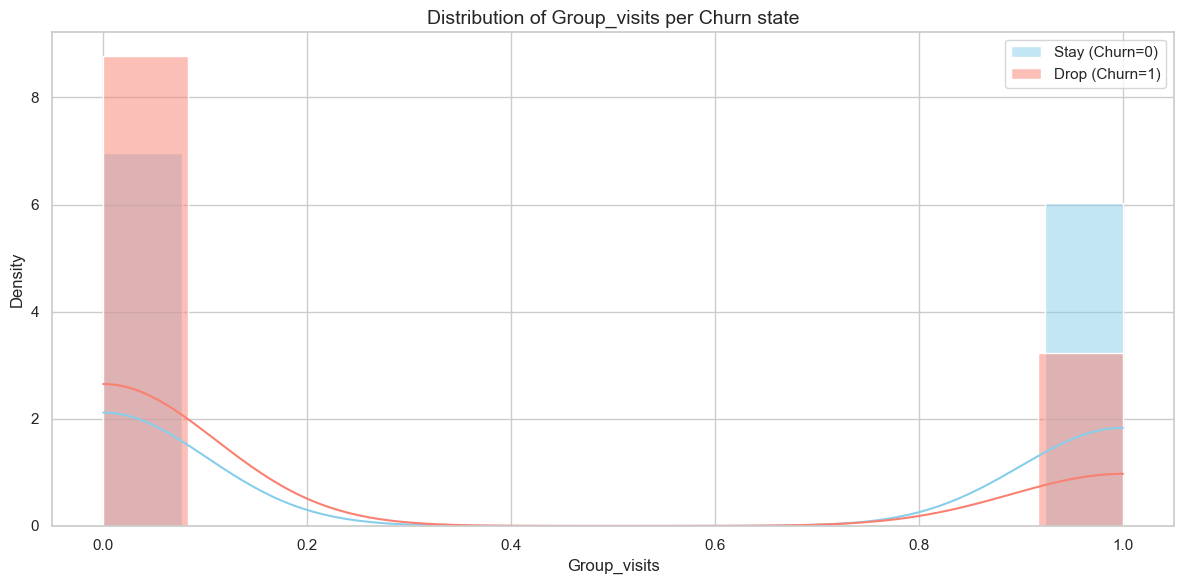

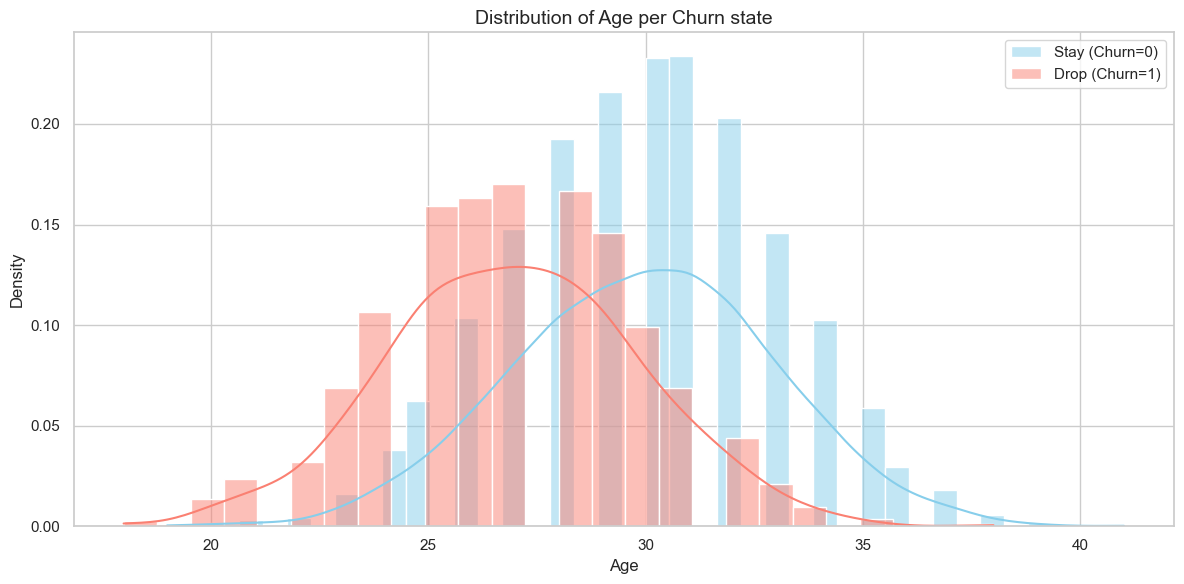

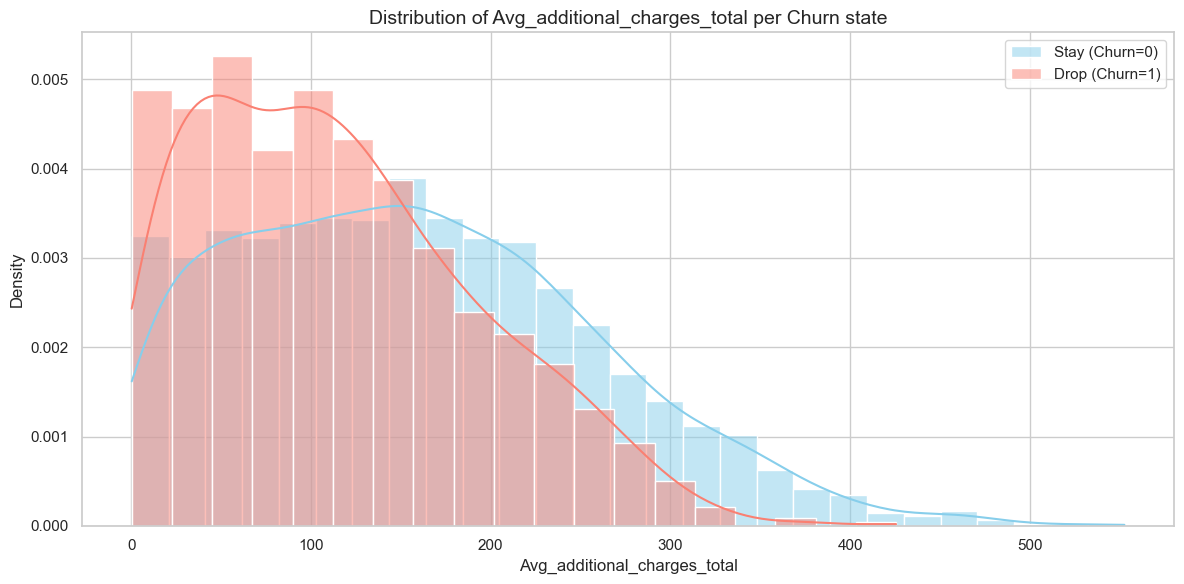

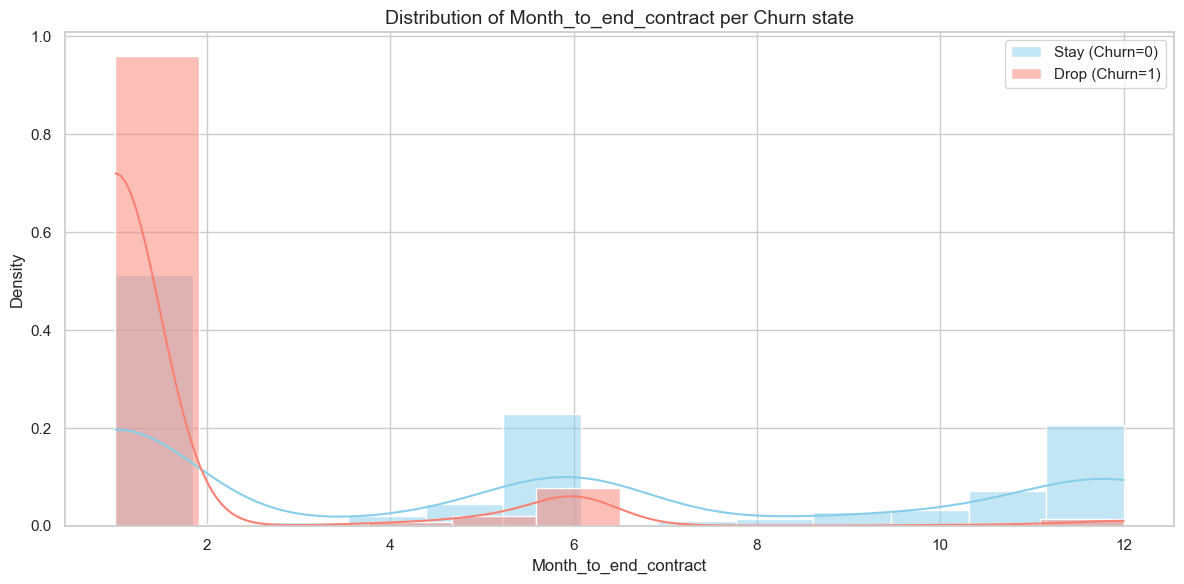

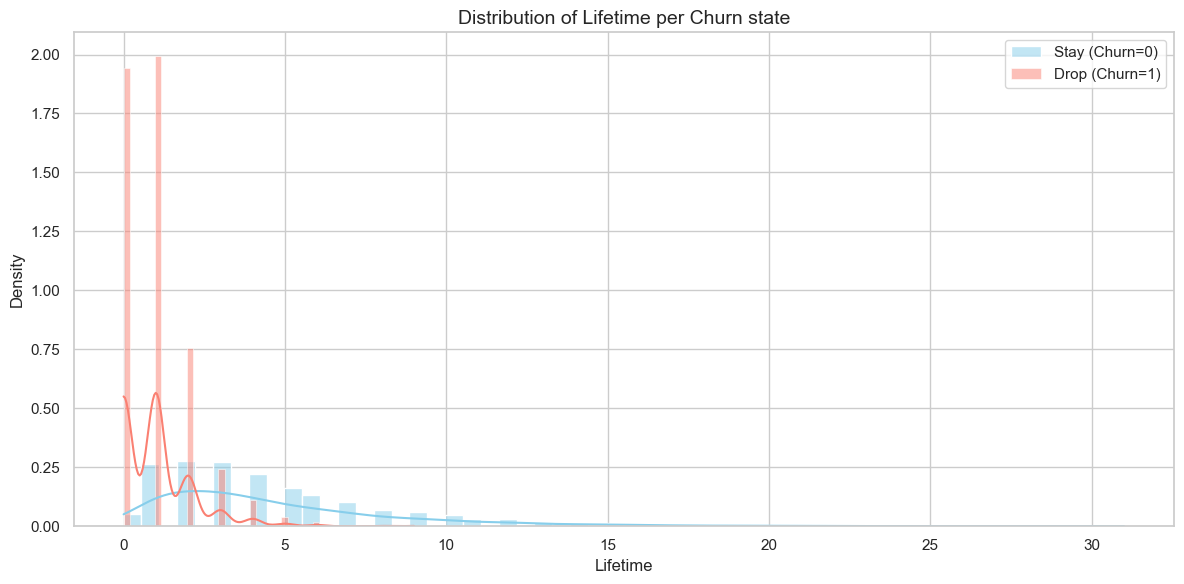

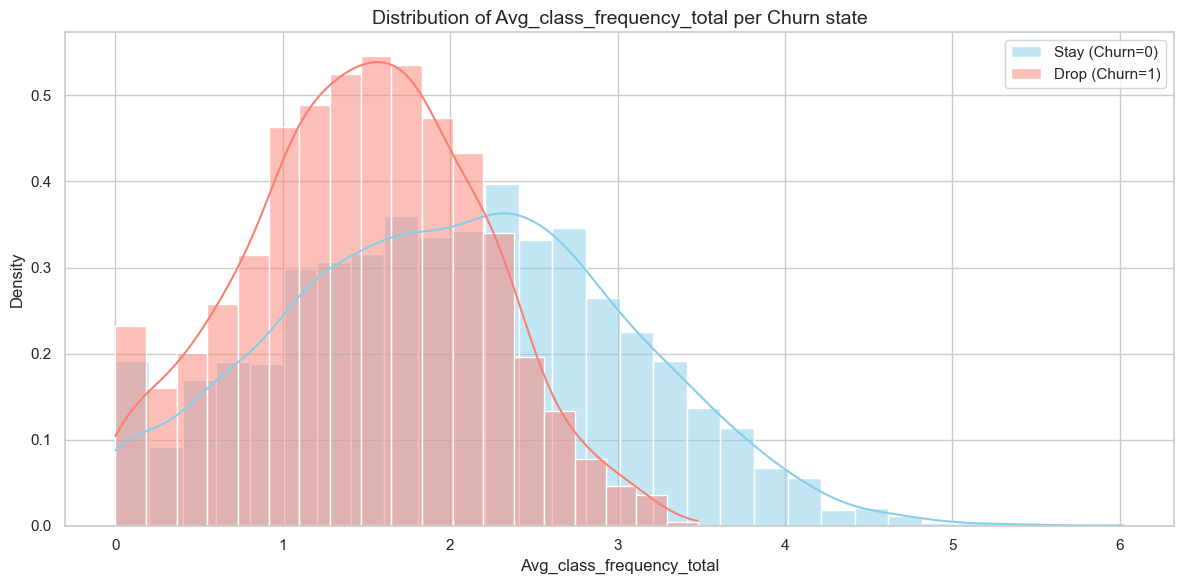

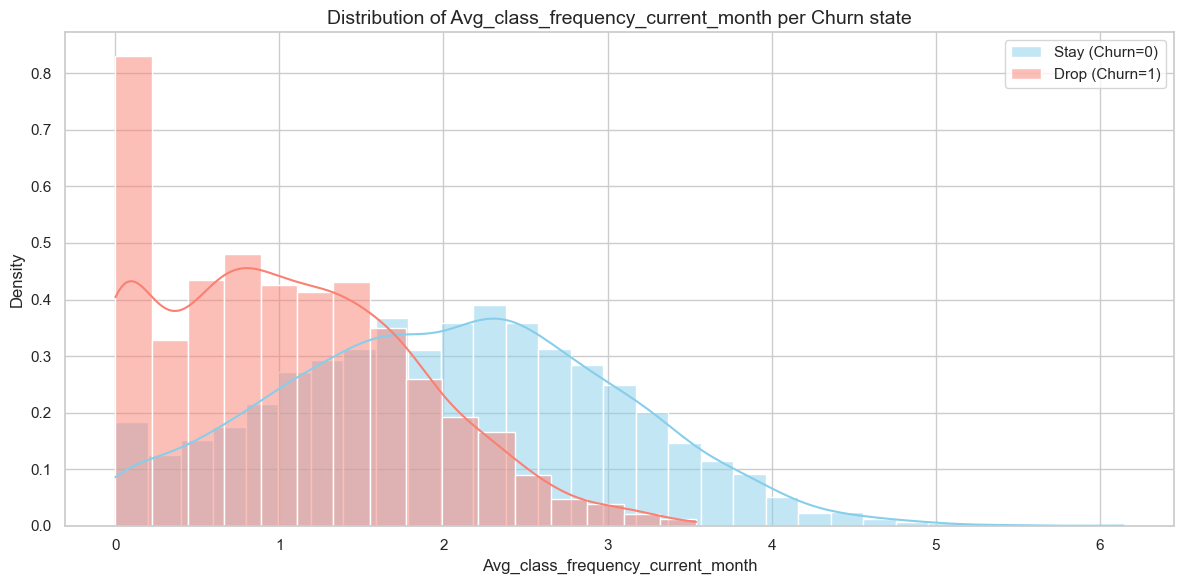

In [6]:
df_stayed = df[df['Churn'] == 0]
df_left = df[df['Churn'] == 1]

features = df.columns.drop('Churn')

sns.set(style="whitegrid")

for feature in features:
    plt.figure(figsize=(12, 6))
    
    # Histogram for those who stayed (Churn=0)
    sns.histplot(
        data=df_stayed, 
        x=feature, 
        color="skyblue", 
        label="Stay (Churn=0)", 
        kde=True,
        alpha=0.5,
        stat="density"
    )
    
    # Histogram for those who left (Churn=1)
    sns.histplot(
        data=df_left, 
        x=feature, 
        color="salmon", 
        label="Drop (Churn=1)", 
        kde=True,
        alpha=0.5,
        stat="density"
    )
    
    plt.title(f'Distribution of {feature} per Churn state', fontsize=14)
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()
    

### Distribution of Relevant Features by Cancellation

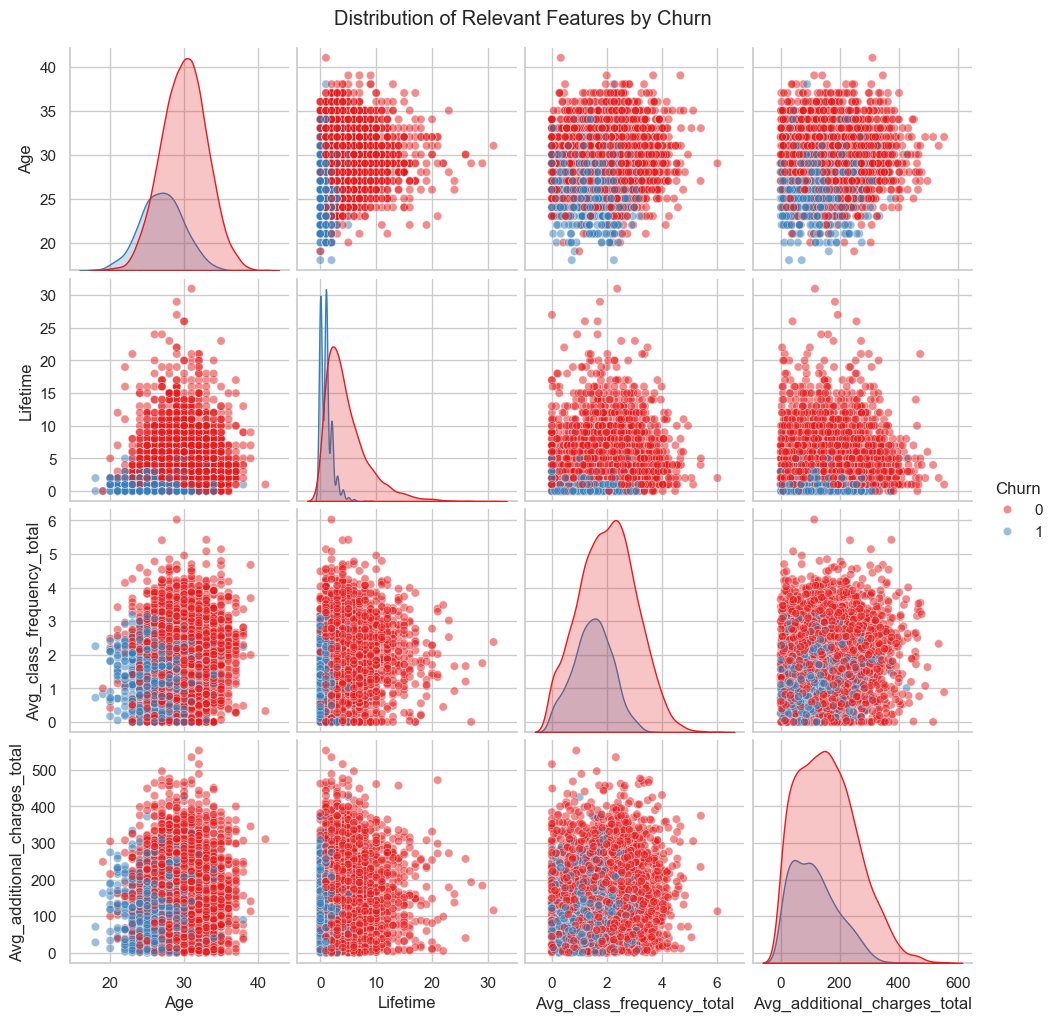

In [7]:
# Most relevant features for churn analysis
selected_features = ['Age', 'Lifetime', 'Avg_class_frequency_total', 
                     'Avg_additional_charges_total', 'Churn']

# Pairplot with hue = 'Churn'
sns.pairplot(df[selected_features], hue='Churn', palette='Set1', diag_kind='kde', plot_kws={'alpha': 0.5})
plt.suptitle('Distribution of Relevant Features by Churn', y=1.02)
plt.show()

**Correlation map**

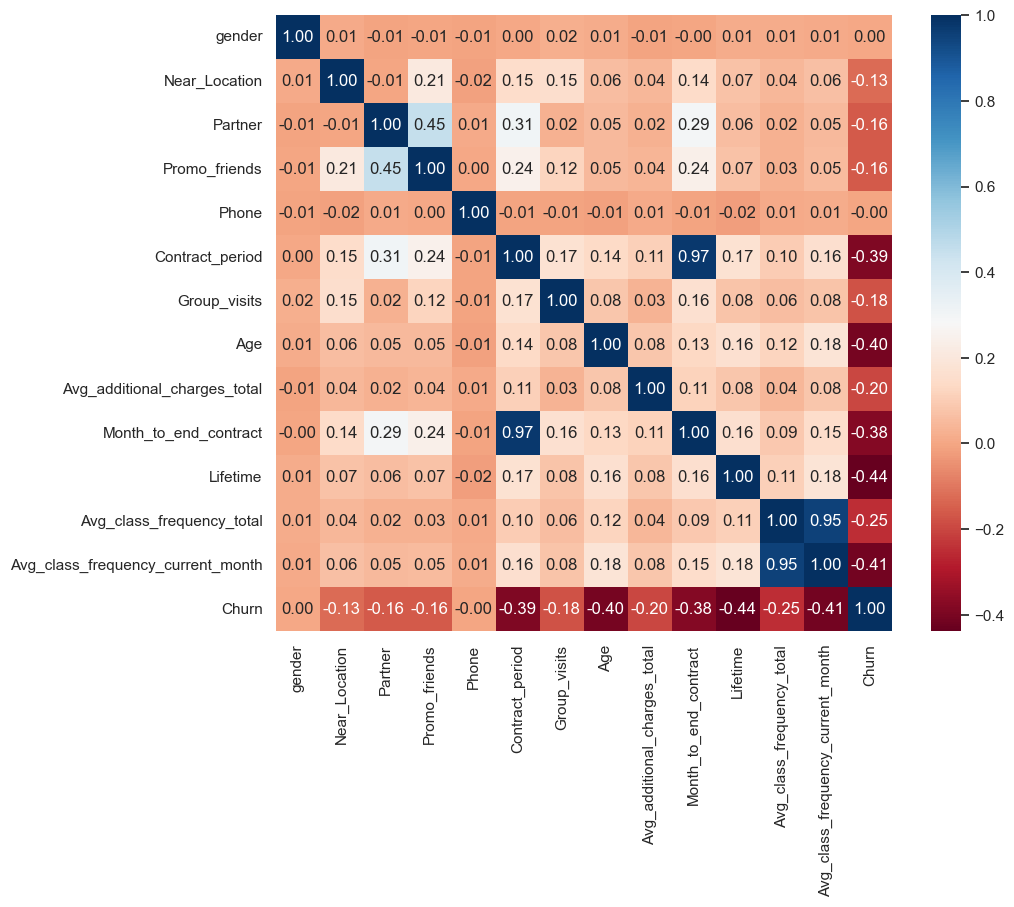

In [8]:
#correlation map
cm = df.corr()
plt.figure(figsize=(10, 8))
# create heatmap
sns.heatmap(cm, annot = True, fmt='.2f', square=True, cmap='RdBu')
plt.show()

## Create prediction model

Random Forest

In [9]:
# divide the data into features and target variable
X = df.drop('Churn', axis=1)
y= df['Churn']

# define the function that will generate our metrics
def print_all_metrics(y_true, y_pred, y_proba, title = 'Classification Metrics'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))


# divide the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

rf_model = RandomForestClassifier(n_estimators = 100, random_state=42)
# train the random forest model
rf_model.fit(X_train, y_train)
# use the trained model to make predictions
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:,1]
# show all metrics
print_all_metrics(y_test, rf_predictions, rf_probabilities, title = 'Random Forest Metrics:')



Random Forest Metrics:
	Accuracy: 0.93
	Precision: 0.87
	Recall: 0.86
	F1: 0.86
	ROC_AUC: 0.98


LogisticRegression

In [10]:
#We already divided the data into training and test sets, now we will standardize the features
#use StandardScaler to standardize the features
scaler = StandardScaler()
scaler.fit(X_train)

# transform training and test sets
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# define the algorithm for the logistic regression model
lr_model = LogisticRegression(random_state=0)
# train the model
lr_model.fit(X_train_st, y_train)
# use the trained model to make predictions
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]
# show all metrics
print_all_metrics(y_test, lr_predictions, lr_probabilities , title='Logistic Regression Metrics:')

Logistic Regression Metrics:
	Accuracy: 0.93
	Precision: 0.87
	Recall: 0.85
	F1: 0.86
	ROC_AUC: 0.98


**Conclusions** <br>

Implement __Logistic Regression__ as the main model, although both models are outstanding, the regression stands out a little more.

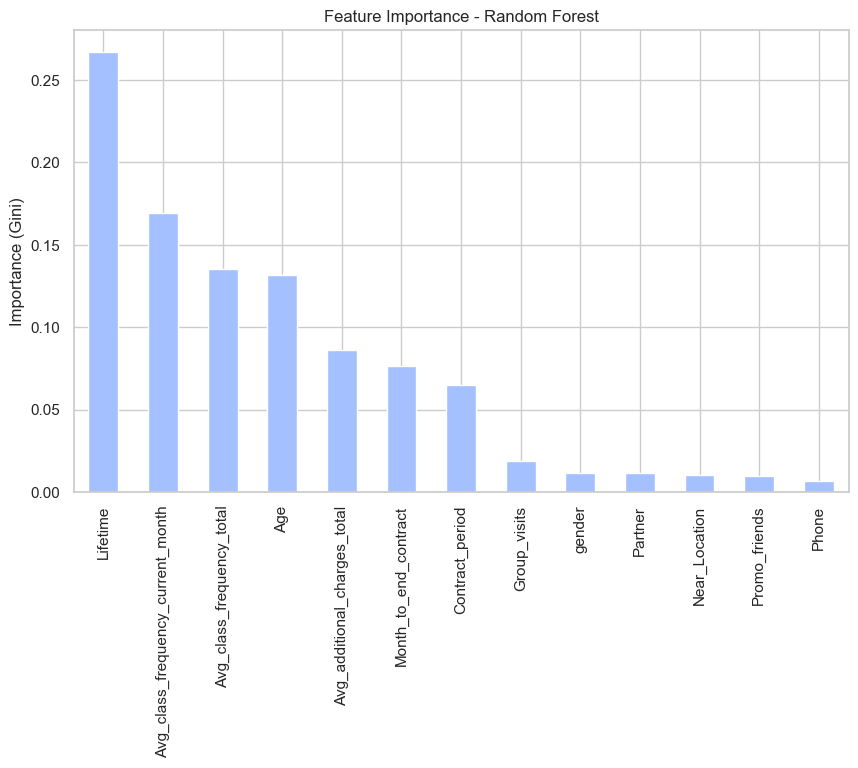

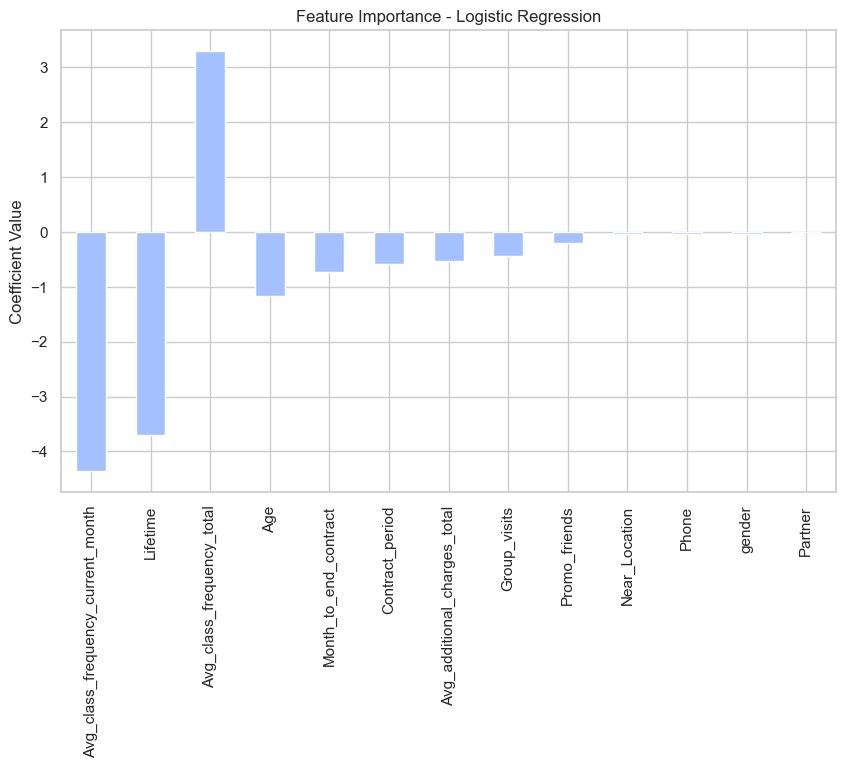

In [11]:
# for random forest feature importance
importances = rf_model.feature_importances_
feature_names = X.columns

forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
forest_importances.plot(kind='bar', color='#a4c0ff')
plt.title("Feature Importance - Random Forest")
plt.ylabel("Importance (Gini)")
plt.show()

# Logistic Regression feature importance
coefs = lr_model.coef_[0]
lr_importances = pd.Series(coefs, index=feature_names).sort_values(key=abs, ascending=False)

plt.figure(figsize=(10, 6))
lr_importances.plot(kind='bar', color='#a4c0ff')
plt.title("Feature Importance - Logistic Regression")
plt.ylabel("Coefficient Value")
plt.show()



We see that the two main characteristics are the **average class frenqeuncy on the month** and the **lifetime** of the client

## Cluster Creation

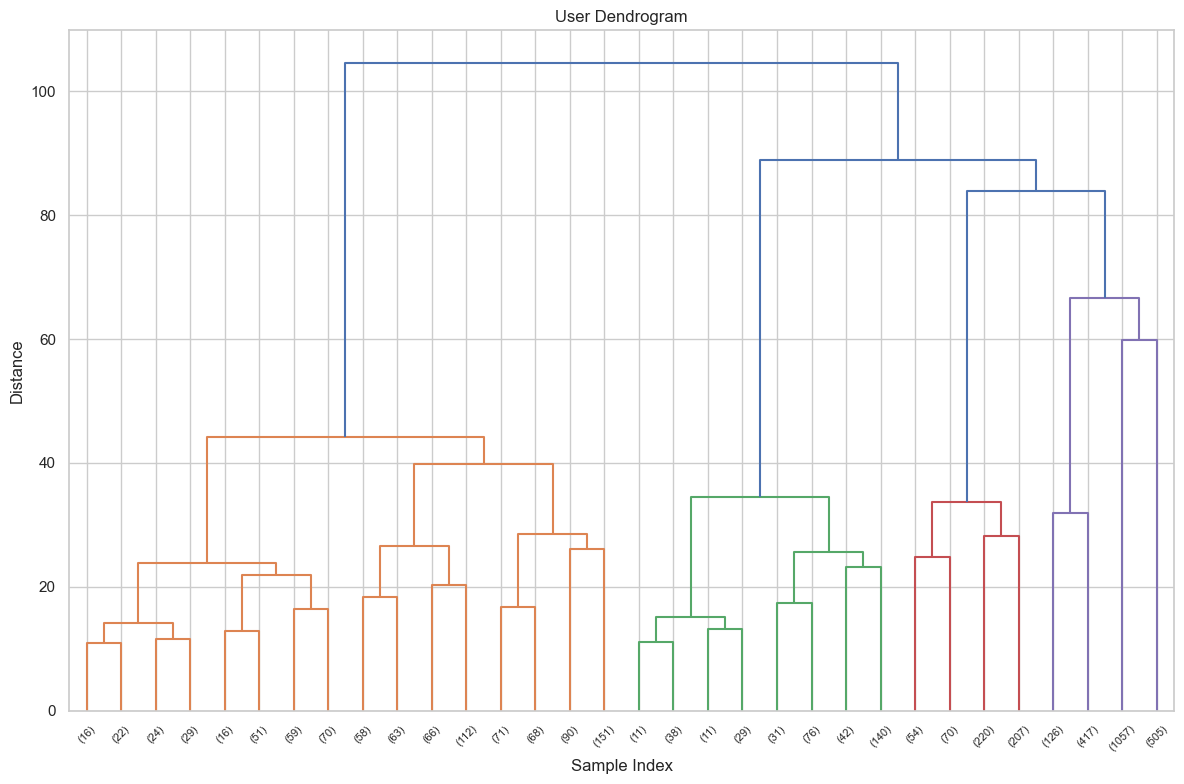

In [12]:
#divide the data into features and target variable for clustering
features = df.drop(columns=['Churn'])

# standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# calculate the linkage matrix
Z = linkage(X_scaled, method='ward')

# dendrogram
plt.figure(figsize=(12, 8))
dendrogram(
    Z,
    truncate_mode='level',  # to speed up and summarize (shows only the first levels)
    p=4                  # number of levels to show
)
plt.title('User Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

Valores medios

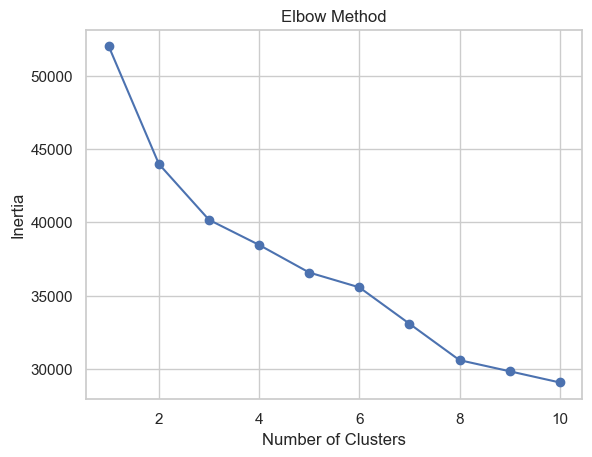

In [13]:
inertia = []
for n in range(1, 11):
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [14]:
#we used the elbow method to determine the optimal number of clusters = 3
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

print(df['cluster'].value_counts().sort_index())
mean = df.groupby('cluster').mean()
display(mean)


cluster
0    1538
1    1055
2     653
3     754
Name: count, dtype: int64


gender  Near_Location   Partner  Promo_friends     Phone  \
cluster                                                               
0        0.488296       0.750975  0.369311       0.171001  0.908322   
1        0.544076       0.857820  0.322275       0.205687  0.911848   
2        0.505360       0.889740  0.529862       0.000000  0.880551   
3        0.511936       0.981432  0.919098       1.000000  0.901857   

         Contract_period  Group_visits        Age  \
cluster                                             
0               1.650195      0.282185  28.022757   
1               1.993365      0.422749  29.899526   
2              10.584992      0.517611  29.995406   
3               9.511936      0.571618  29.850133   

         Avg_additional_charges_total  Month_to_end_contract  Lifetime  \
cluster                                                                  
0                          127.610632               1.587776  2.170351   
1                          158.293891               1.891943  4.750711   
2                          161.970237               9.652374  4.721286   
3                          157.484271               8.687003  4.596817   

         Avg_class_frequency_total  Avg_class_frequency_current_month  \
cluster                                                                 
0                         1.214815                           0.944731   
1                         2.743418                           2.729568   
2                         1.965719                           1.952262   
3                         1.949300                           1.937253   

            Churn  
cluster            
0        0.585176  
1        0.098578  
2        0.041348  
3        0.039788

Those in cluster number 0 are the ones who are most likely to quit the gym and are also the ones who have the least on average of everything.

### Important features

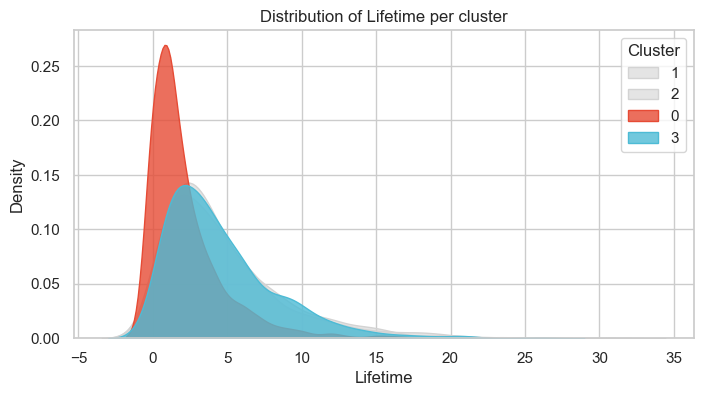

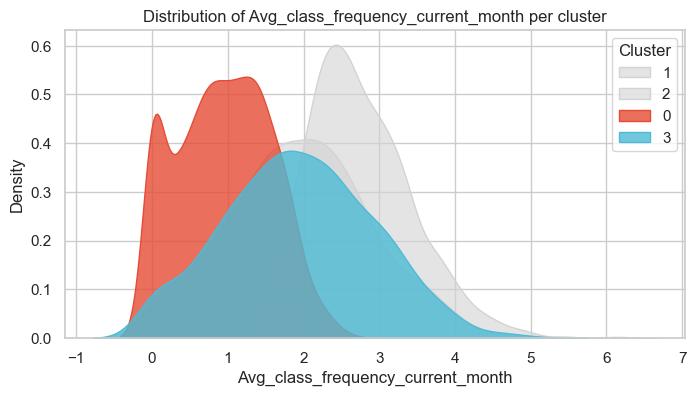

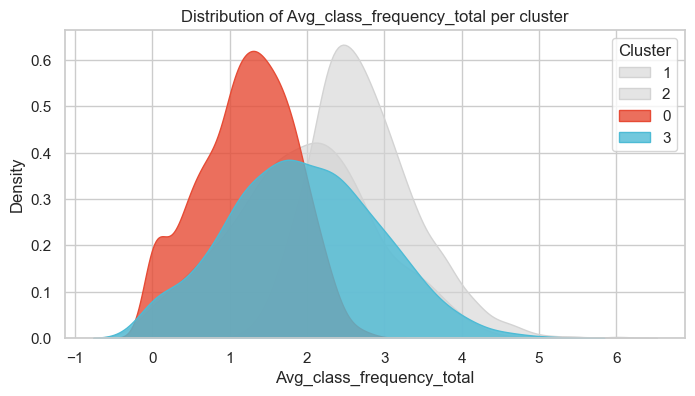

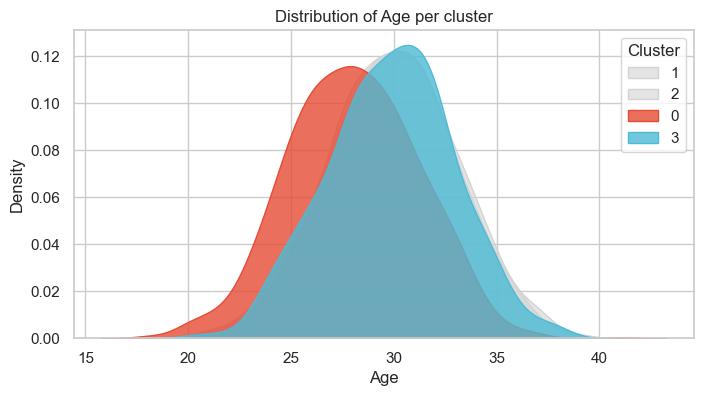

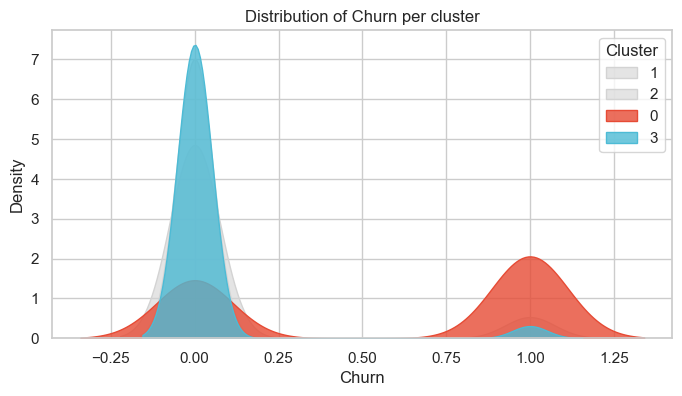

In [15]:
#important features
features = [
    'Lifetime',
    'Avg_class_frequency_current_month',
    'Avg_class_frequency_total',
    'Age',
    'Churn',
]

palette = {
    0: "#E64B35",
    1: "lightgrey",
    2: "lightgrey",   
    3: "#4DBBD5",   
}

for var in features:
    plt.figure(figsize=(8, 4))

  
    for c in [1, 2]:
        sns.kdeplot(
            data=df[df['cluster'] == c],
            x=var,
            fill=True,
            common_norm=False,
            alpha=0.6,
            color=palette[c],
            zorder=1  
        )

    
    for c in [0, 3]:
        sns.kdeplot(
            data=df[df['cluster'] == c],
            x=var,
            fill=True,
            common_norm=False,
            alpha=0.8,      
            color=palette[c],
            zorder=2        
        )

    plt.title(f'Distribution of {var} per cluster')
    plt.xlabel(var)
    plt.ylabel('Density')
    plt.legend(title='Cluster', labels=[1, 2, 0, 3])
    plt.show()

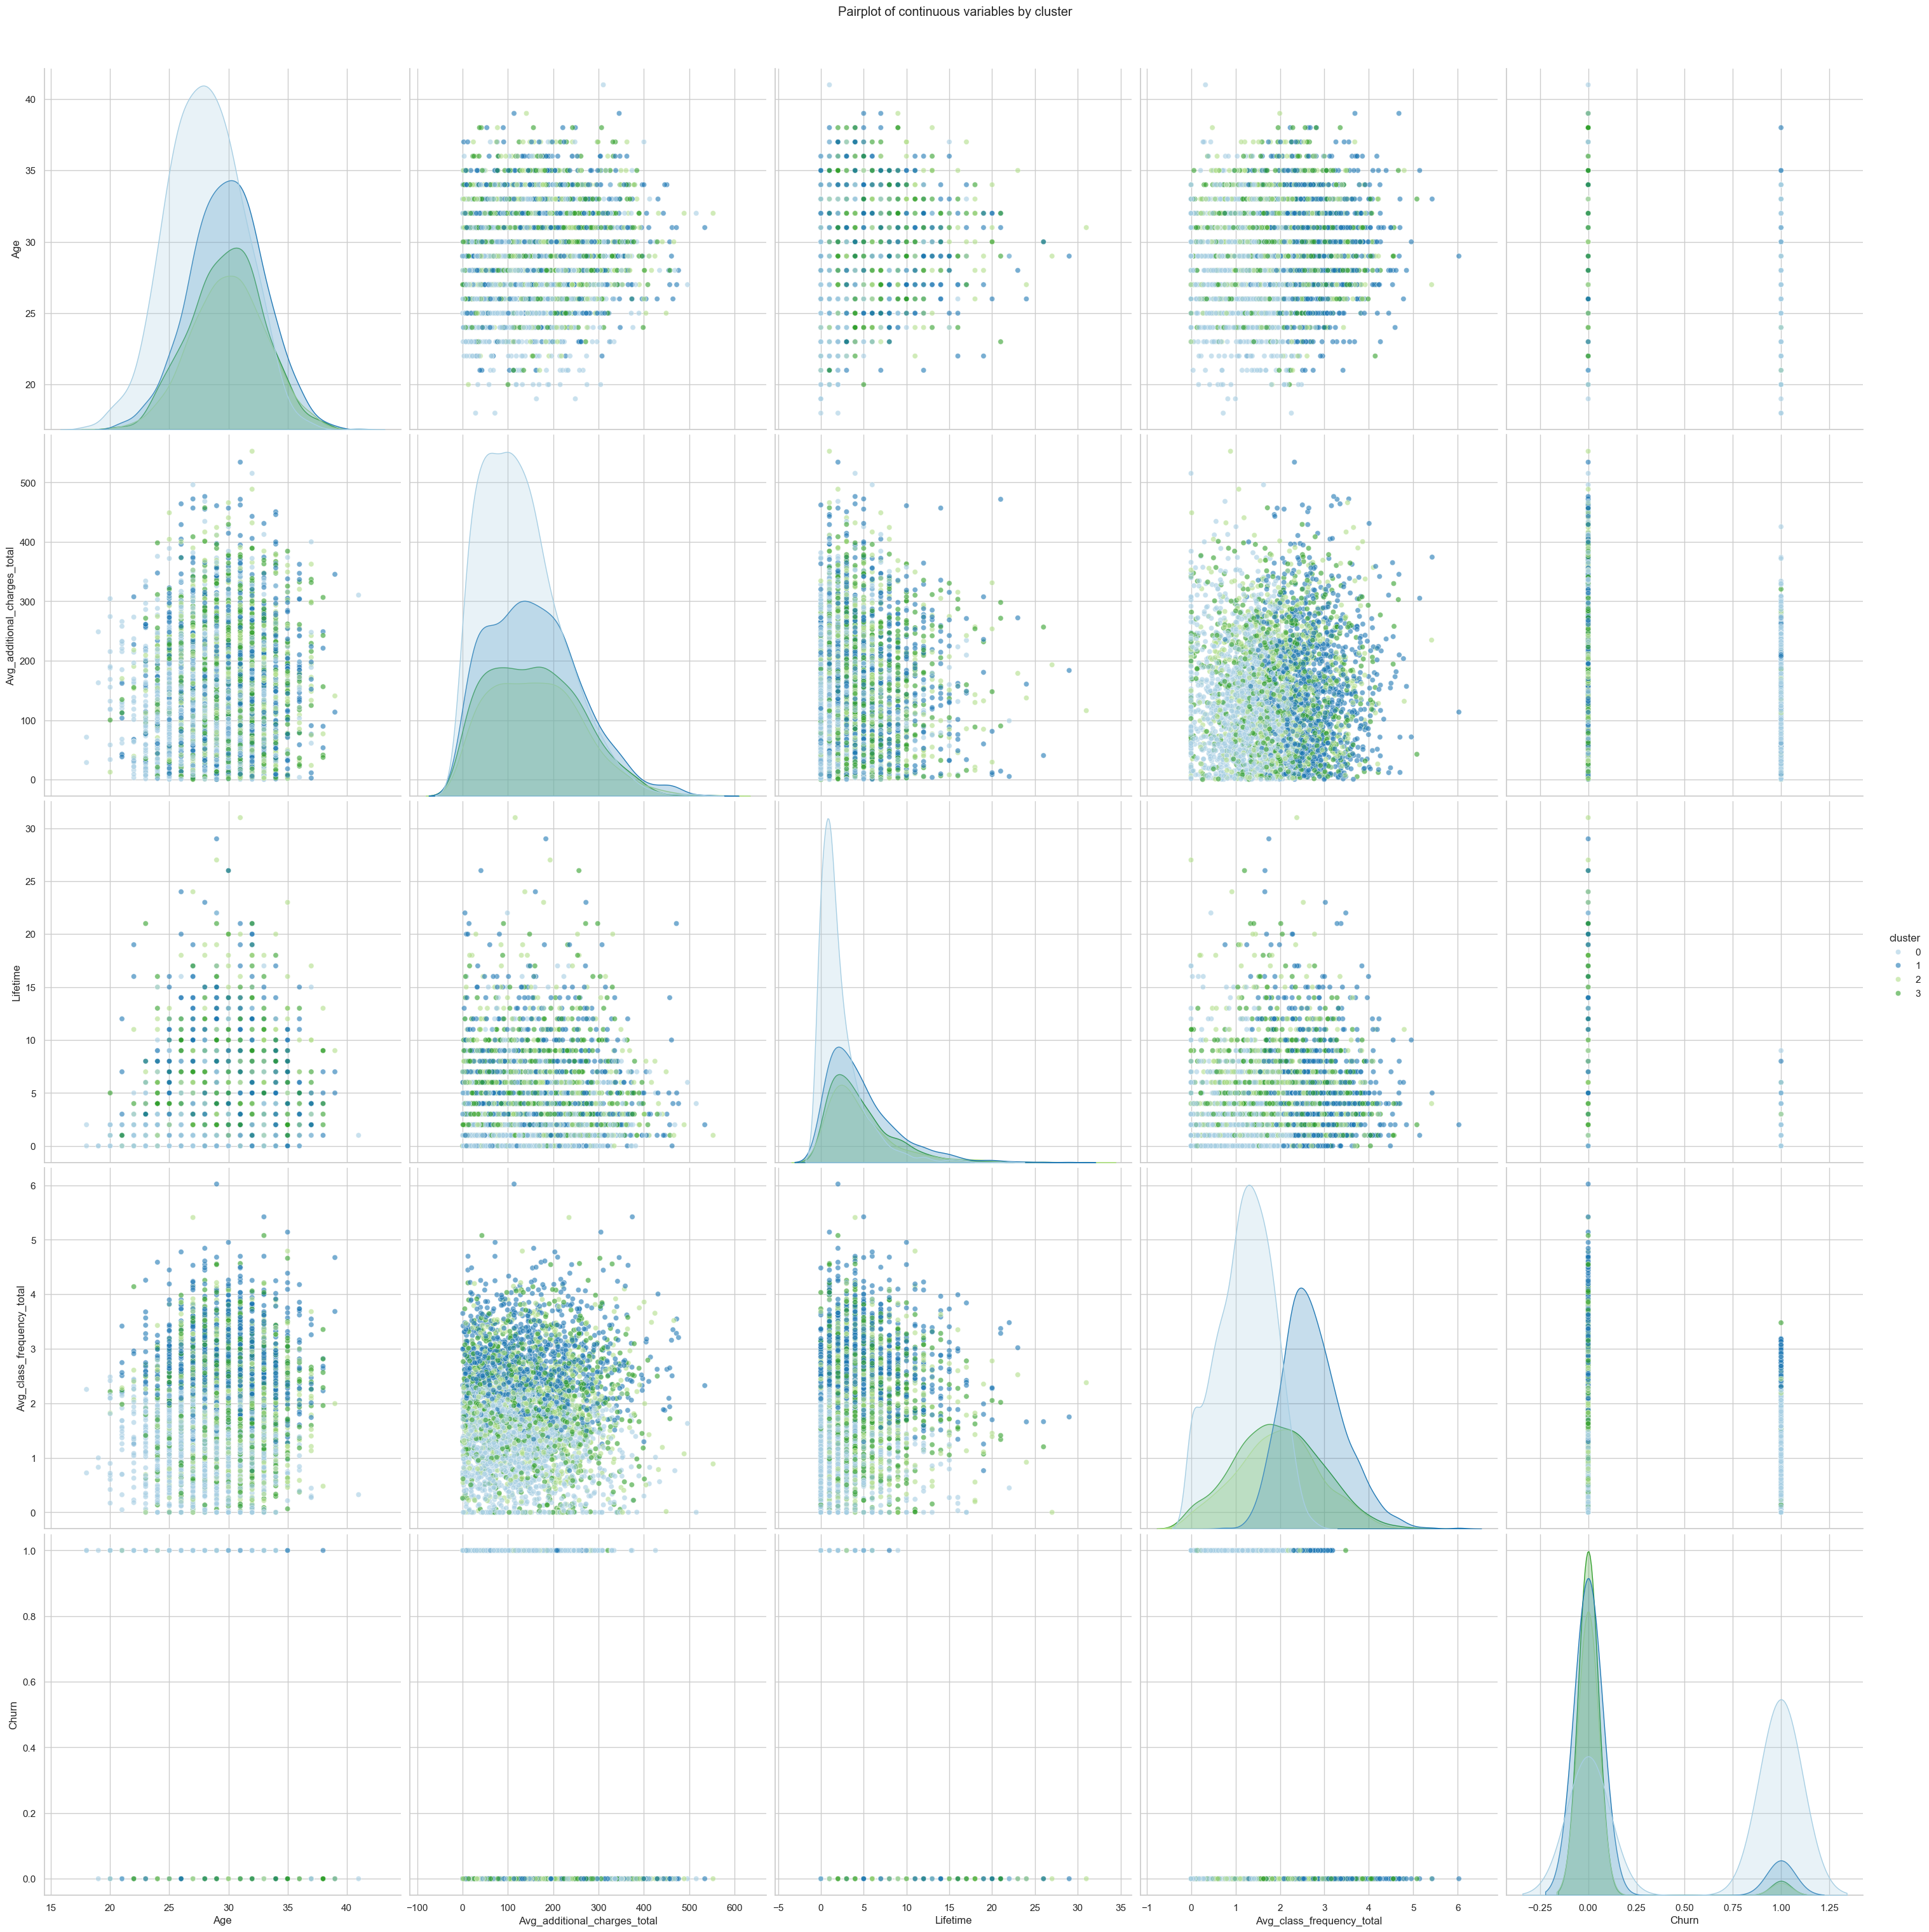

In [16]:
sns.pairplot(
    df,

    vars=['Age', 'Avg_additional_charges_total', 'Lifetime', 'Avg_class_frequency_total', 'Churn'],
    hue='cluster',
    diag_kind='kde',
    plot_kws={'alpha': 0.6},
    palette='Paired',
    height=6,      
    aspect=1
)
plt.suptitle('Pairplot of continuous variables by cluster', y=1.02)
plt.show()


**Cancelation Rate**

In [17]:
churn_cluster = df.groupby('cluster')['Churn'].mean().sort_values(ascending=False)
display(churn_cluster)

cluster
0    0.585176
1    0.098578
2    0.041348
3    0.039788
Name: Churn, dtype: float64

The groups most likely to leave are those in cluster 0, while the most loyal are those in cluster 3.

In [18]:
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

print(df['cluster'].value_counts().sort_index())
mean = df.groupby('cluster').mean()
display(mean)


cluster
0    1283
1     633
2     646
3     544
4     894
Name: count, dtype: int64


gender  Near_Location   Partner  Promo_friends     Phone  \
cluster                                                               
0        0.484801       0.698363  0.301637       0.007015  0.899454   
1        0.494471       0.947867  0.791469       0.998420  0.906793   
2        0.464396       0.913313  0.766254       0.493808  0.925697   
3        0.547794       0.937500  0.742647       0.424632  0.863971   
4        0.568233       0.878076  0.178971       0.048098  0.914989   

         Contract_period  Group_visits        Age  \
cluster                                             
0               1.733437      0.255651  28.074825   
1               2.740916      0.431280  28.903633   
2              10.495356      0.506192  30.091331   
3              11.194853      0.575368  29.720588   
4               2.120805      0.456376  29.993289   

         Avg_additional_charges_total  Month_to_end_contract  Lifetime  \
cluster                                                                  
0                          127.131782               1.657833  2.089634   
1                          139.456908               2.540284  3.529226   
2                          164.190347               9.484520  4.693498   
3                          167.670439              10.347426  4.818015   
4                          155.602830               2.013423  4.844519   

         Avg_class_frequency_total  Avg_class_frequency_current_month  \
cluster                                                                 
0                         1.256531                           0.991781   
1                         1.619489                           1.488508   
2                         2.888801                           2.886027   
3                         1.154578                           1.139605   
4                         2.667290                           2.650122   

            Churn  
cluster            
0        0.587685  
1        0.285940  
2        0.013932  
3        0.042279  
4        0.105145

By applying the cluster method to divide them into groups and the similarity of their characteristics, we realize that group 3 is the one that tends to drop out the most. The most important characteristics to take into account are: ['Age', 'Avg_additional_charges_total', 'Lifetime', 'Avg_class_frequency_total',] and it is clearly seen that those in group 3 tend to have all these characteristics with a low average compared to the other clusters.

## Conclusion

Cluster analysis suggests that certain variables play a decisive role in the likelihood of churn, particularly age, average total additional charges, customer lifetime, and class attendance frequency. Based on this, four key strategies are recommended: (1) segment by age to adapt the offering and communication tone to different generational profiles; (2) reward those who generate additional revenue (through additional services or products) with exclusive benefits that reinforce their perceived value; (3) focus early actions on new customers, especially during their first months of life, through guided onboarding and proactive follow-up; and (4) encourage consistent attendance by offering monthly challenges, frequency rewards, or motivational messages. Implementing these actions in a segmented and automated manner can significantly increase retention and strengthen the emotional connection with the brand.